Trains a polynomial approximation for the sigmoid function, for x belonging in a specific range of values. The polynomial is 2nd order by default, but higher order approximations can be trained by adjusting the `order` parameter of `getAndGraphApproximator`.

Default approximation formula:

$σ(x) = a_2 (x - \text{offset})^2 + a_1 (x - \text{offset}) + a_0, x \in [\text{lowerBound}, \text{upperBound}]$

Where $a_0, a_1, a_2$ are trainable parameters and offset = lowerBbound

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

%matplotlib inline

In [ ]:
def sigmoid_numpy(x):
    return 1.0 / (1.0 + np.exp(-x))

# Neural network to find approximation formulae for the sigmoid function in a given range. We look for solutions with the general form of an N-order polynomial
# By piecing together multiple of these solutions for different boundaries, with some fixups (to guarantee monotony/continuity, etc) we can derive a 
# very good, hardware-friendly sigmoid approximation
class SigmoidApproximator(nn.Module):
    def __init__(self, lowerBound, upperBound, order):
        assert lowerBound < upperBound
        super(SigmoidApproximator, self).__init__()

        self.lowerBound = lowerBound
        self.upperBound = upperBound
        self.terms = nn.Parameter(torch.randn(order + 1))
        self.offsetTerm = torch.Tensor([self.lowerBound])

        self.lossFn = nn.MSELoss()
        
    def forward(self, x):
        sum = torch.broadcast_to(self.terms[0], x.shape)
        x_power = torch.ones_like(x)
        x_multiplier = x - torch.broadcast_to(self.offsetTerm, x.shape)
        
        for i in range(1, len(self.terms)):
            x_power = x_power * x_multiplier
            sum = sum + x_power * self.terms[i]
        return sum
    
    def loss(self, y_pred, y_true):
        # Apply penalty for any values outside [0, 1], the proper output range of the sigmoid function
        penalty = 0.0
        penaltyFactor = 0
        
        # Penalties if prediction is < 0 or > 1
        penalty += torch.sum(torch.relu(-y_pred)) * penaltyFactor
        penalty += torch.sum(torch.relu(y_pred - 1.0)) * penaltyFactor
        
        # Total loss = MSE loss + penalty
        return self.lossFn(y_pred, y_true) + penalty
    
    def paramsToFloat(self):
        # Convert parameters from tensors to floats and return them
        return (np.array([term.data.float() for term in self.terms]), self.offsetTerm.data.float())

def getSigmoidApproximation(*, lowerBound, upperBound, N, epochs, order):
    nn = SigmoidApproximator(lowerBound, upperBound, order = order)
    nn.train()

    optimizer = torch.optim.Adam(nn.parameters(), lr = 0.001)

    # Generate N samples from lowerBound to upperBound
    x = np.linspace(lowerBound, upperBound, N)
    y_true = torch.Tensor(sigmoid_numpy(x))

    x = torch.Tensor(x)
    
    for epoch in range(0, epochs):
        optimizer.zero_grad()
        y_pred = nn(x)

        loss = nn.loss(y_pred, y_true)
        loss.backward()
        optimizer.step()

    return nn.paramsToFloat()

def plotApproximation(lowerBound, upperBound, terms):
    # Plot full sigmoid function
    x = np.linspace(-8, 8, 10000)
    y = sigmoid_numpy(x)
    plt.plot(x, y, color = "blue", label = "Numpy sigmoid")
    
    terms, offsetTerm = terms

    # Plot approximation for boundary
    x = np.linspace(lowerBound, upperBound, 10000)
    y = np.broadcast_to(terms[0], x.shape)
    x_power = np.ones_like(x)
    x_multiplier = x - np.broadcast_to(offsetTerm, x.shape)

    for i in range(1, len(terms)):
        x_power *= x_multiplier
        y = y + x_power * terms[i]
    
    plt.plot(x, y, color = "orange", label = "Approximation for given boundary")

    plt.legend()
    plt.show()
    
def printParameters(lowerBound, upperBound, terms):
    coefficients, offset = terms

    print(f"Estimated parameters for bound [{lowerBound}, {upperBound}]")
    print("Polynomial coefficients:", coefficients)
    print("Offset term: ", offset)

In [23]:
def getAndGraphApproximator(*, lowerBound, upperBound, N = 1000, epochs = 100000, order = 2):
    terms = getSigmoidApproximation(lowerBound = lowerBound, upperBound = upperBound, N = N, epochs = epochs, order = order)
    printParameters(lowerBound, upperBound, terms)
    plotApproximation(lowerBound, upperBound, terms)
    
    return terms

Approximator for $x \in [0.0, 1.0]$

Estimated parameters for bound [0, 1]
Polynomial coefficients: [ 0.4991591   0.26048374 -0.02786621]
Offset term:  tensor([0.])


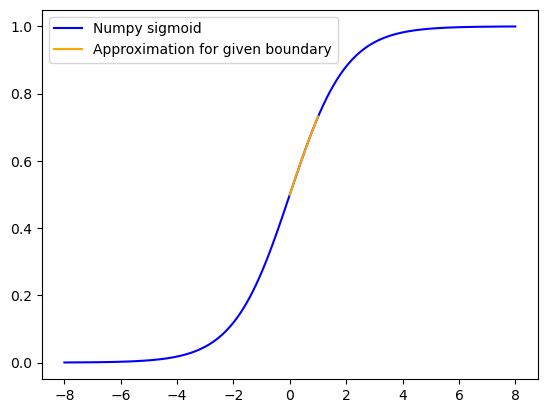

(array([ 0.4991591 ,  0.26048374, -0.02786621], dtype=float32), tensor([0.]))

In [24]:
lower, upper = 0, 1

getAndGraphApproximator(lowerBound = lower, upperBound = upper)

Approximator for $x \in [1.0, 2.0]$

Estimated parameters for bound [1, 2]
Polynomial coefficients: [ 0.73112386  0.19620562 -0.04669973]
Offset term:  tensor([1.])


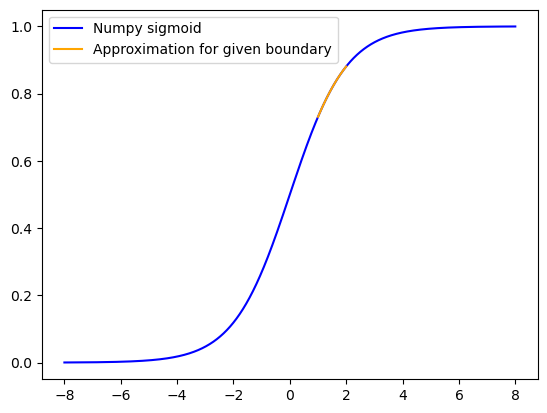

(array([ 0.73112386,  0.19620562, -0.04669973], dtype=float32), tensor([1.]))

In [25]:
lower, upper = 1, 2

getAndGraphApproximator(lowerBound = lower, upperBound = upper)

Approximator for $x \in [2.0, 3.0]$

Estimated parameters for bound [2, 3]
Polynomial coefficients: [ 0.88113385  0.10092597 -0.02981323]
Offset term:  tensor([2.])


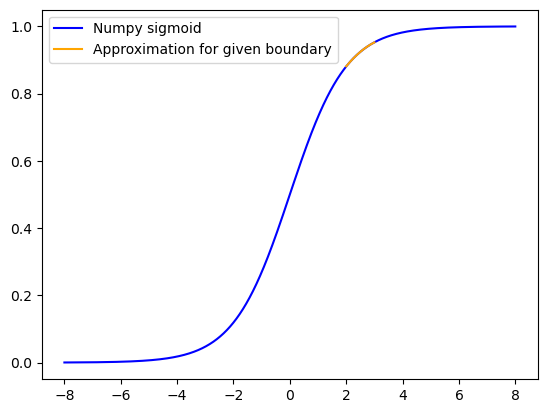

(array([ 0.88113385,  0.10092597, -0.02981323], dtype=float32), tensor([2.]))

In [26]:
lower, upper = 2, 3

getAndGraphApproximator(lowerBound = lower, upperBound = upper)

Approximator for $x \in [3, 4]$

Estimated parameters for bound [3, 4]
Polynomial coefficients: [ 0.9527815   0.04259519 -0.01354958]
Offset term:  tensor([3.])


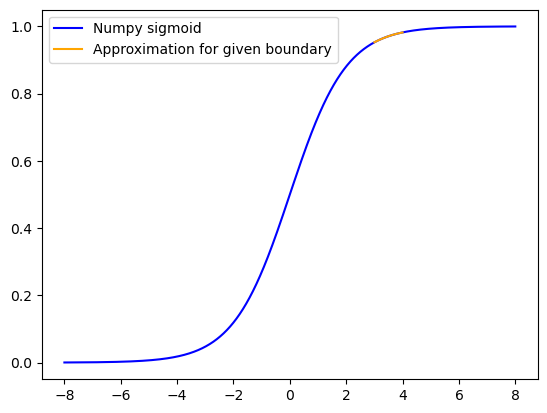

(array([ 0.9527815 ,  0.04259519, -0.01354958], dtype=float32), tensor([3.]))

In [27]:
lower, upper = 3, 4

getAndGraphApproximator(lowerBound = lower, upperBound = upper)

Approximator for $x \in [4, 5]$

Estimated parameters for bound [4, 5]
Polynomial coefficients: [ 0.9820759   0.01649015 -0.00542559]
Offset term:  tensor([4.])


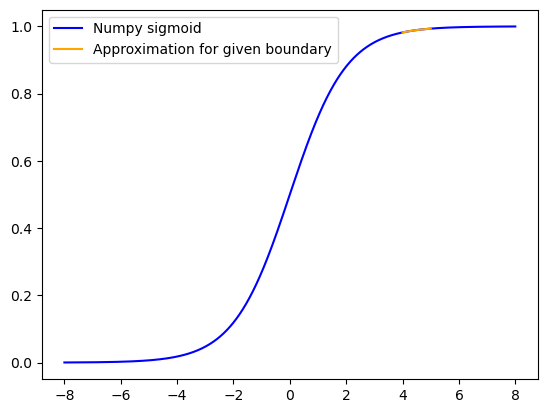

(array([ 0.9820759 ,  0.01649015, -0.00542559], dtype=float32), tensor([4.]))

In [28]:
lower, upper = 4, 5

getAndGraphApproximator(lowerBound = lower, upperBound = upper)

Approximator for $x \in [5, 6]$

Estimated parameters for bound [5, 6]
Polynomial coefficients: [ 0.9933426   0.00619787 -0.00204496]
Offset term:  tensor([5.])


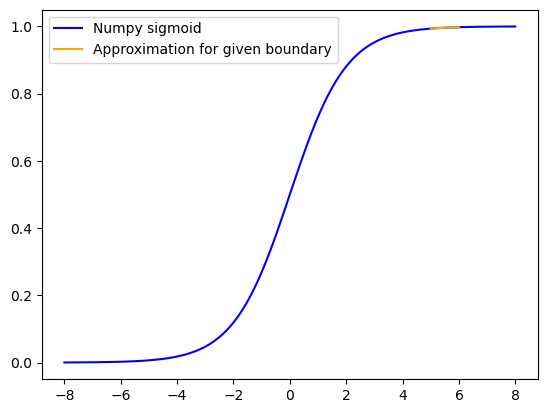

(array([ 0.9933426 ,  0.00619787, -0.00204496], dtype=float32), tensor([5.]))

In [29]:
lower, upper = 5, 6

getAndGraphApproximator(lowerBound = lower, upperBound = upper)

σ(x) for x >= ~6 is practically 0.99999...

In [30]:
print(sigmoid_numpy(6.9))

0.9989932291799144
